# Assessment on the relation between COVID-19 cases and intercity mobility in Brazil.

This notebook aims to find a relationship between Covid-19 cases and intercity human mobility (flow) in Brazil. 

The assessment was made with 2 different approaches:

* 1 - Considering total Covid-19 cases.
* 2 - Considering Covid-19 cases per 100,000 inhabitants.

In each of these aproaches, it was used 2 different geographical scales: 
* a -  Municipal scale, where each instance is a city and considers all of cities of Brazil.
* b - State scale, where each instance is a state and considers all states of Brazil.
* c - Municipal scale, where each instance is a city and considers the cities of each state of Brazil.


Importing the libraries

In [162]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import math
#import cv2 #Open CV
import scipy.signal
import matplotlib.image as mpimg
import csv
import seaborn as sns

Opening and processing COVID-19 and mobility data


In [153]:
#Covid-19 data
cases_covid_br = pd.read_csv('input/covid/cases-brazil-cities.txt',usecols=['ibgeID','totalCases','state','totalCases_per_100k_inhabitants'])
cases_covid_br['state_id'] = cases_covid_br['ibgeID'].apply(lambda x: str(x)[:2])
UFS = sorted(cases_covid_br['state_id'].unique())
UFS_names = cases_covid_br[['state','state_id']].sort_values('state_id')['state'].unique()
cases_covid_br['ibgeID'] = cases_covid_br['ibgeID'].apply(lambda x: str(x)[:-1])
delay_covid_br = pd.read_csv('input/covid/delay_cases_BR.csv',usecols=['ibgeID','delay'])
delay_covid_br['ibgeID'] = delay_covid_br['ibgeID'].apply(lambda x: str(x)[:-1])
covid_br = pd.merge(cases_covid_br, delay_covid_br, on='ibgeID')
covid_br['population'] = ((covid_br['totalCases']*100000)/covid_br['totalCases_per_100k_inhabitants']).astype('int')

#Flow data
flow_br = pd.read_csv('input/flow/br.csv', sep=';')
flow_br['from'] = flow_br['from'].astype(str)
flow_br['to'] = flow_br['to'].astype(str)

Defining functions that allows processing and aggregating the mobility and COVID-19 data for different geographical regions

In [154]:
def df_flow(geocodes=None, OD = 'BR'):
    '''
    Returns a Pandas DataFrame with Flow/Distance data for each city pair, for the chosen cities/states.
    
    Parameters
    ------------
    geocodes: list with State IDs (2 digits) or municipalities IDS (6 digits).
    OD: origin/destination considered do delimit. 'BR' considers OD in all brazil. 'Self' considers OD just within the cities specified with the geocodes
    If a list of states is passed, considers OD within the specified state
    ------------
    '''
    flow_br = pd.read_csv('input/flow/br.csv', sep=';')
    flow_br['from'] = flow_br['from'].astype(str)
    flow_br['to'] = flow_br['to'].astype(str)
    if geocodes==None:
        return flow_br
    if len(geocodes[0])==2:
        if OD == 'BR':
            flow_df = flow_br[(flow_br['from'].str[:2].isin(geocodes)) | (flow_br['to'].str[:2].isin(geocodes))]
        elif OD=='self':
            flow_df = flow_br[(flow_br['from'].str[:2].isin(geocodes)) & (flow_br['to'].str[:2].isin(geocodes))]
    else:
        if OD == 'BR':
            flow_df = flow_br[(flow_br['from'].isin(geocodes)) | (flow_br['to'].str[:2].isin(geocodes))]
        elif OD=='self':
            flow_df = flow_br[(flow_br['from'].isin(geocodes)) & (flow_br['to'].isin(geocodes))]
        else:
            flow_df = flow_br[((flow_br['from'].isin(geocodes)) | (flow_br['to'].str[:2].isin(geocodes))) & ((flow_br['from'].str[:2].isin(OD)) & (flow_br['to'].str[:2].isin(OD)))]
    return flow_df


def df_flow_covid(geocodes = None, OD='BR'):
    '''
    Returns a Pandas DataFrame with Covid and flow data for each city.
    
    Parameters
    ------------
    geocodes: list with state IDs (2 digits) or municipalities IDS (6 digits).
    OD: origin/destination considered do delimit. 'BR' considers OD in all brazil. 'Self' considers OD just within the cities specified with the geocodes
    If a list of states is passed, considers OD within the specified state
    -----------
    
    '''
    flow_br = df_flow(geocodes,OD)
    
    BR_ids = covid_br['ibgeID'].unique()
    city_pairs_df = pd.merge(pd.merge(flow_br,covid_br,left_on='from',right_on='ibgeID').drop('ibgeID',axis='columns').rename(
    columns={'totalCases':'from_cases','delay':'from_delay'}), covid_br, left_on='to', right_on='ibgeID').rename(
    columns={'totalCases':'to_cases','delay':'to_delay'}).drop('ibgeID',axis='columns')
    city_pairs_df['cases_sum'] = city_pairs_df['from_cases'] + city_pairs_df['to_cases']
    city_pairs_df['relative_delay'] = np.abs(city_pairs_df['from_delay'] - city_pairs_df['to_delay'])
    city_pairs_df.drop(columns=['from_cases', 'from_delay', 'to_cases', 'to_delay'], inplace=True)
    cities_df = pd.merge(pd.concat([city_pairs_df.groupby(['from'])['flow'].agg('sum'), 
                                city_pairs_df.groupby(['to'])['flow'].agg('sum')]).groupby(level=0).agg('sum'),
                                covid_br.set_index('ibgeID'),left_index=True,right_index=True)
    if geocodes!=None:
        
        if len(geocodes[0])==2:
            city_pairs_df = city_pairs_df[(city_pairs_df['from'].str[:2].isin(geocodes)) & (city_pairs_df['to'].str[:2].isin(geocodes))]
            cities_df = cities_df[cities_df['state_id'].isin(geocodes)]    
        else:
            cities_df = cities_df.reset_index()[cities_df.reset_index()['index'].isin(geocodes)]
    return cities_df

## Approach (1) - Using total COVID-19 data

### Scale (a) - Municipal scale, where each instance is a city, and considers all of cities of Brazil.

There is a considerably positive correlation between people's flow and total COVID-19 cases. That possibly means that cities that has a high flow of people that comes from or go to other cities, are likely to have more COVID-19 cases. Is that really true? We'll find out by the end of this notebook.


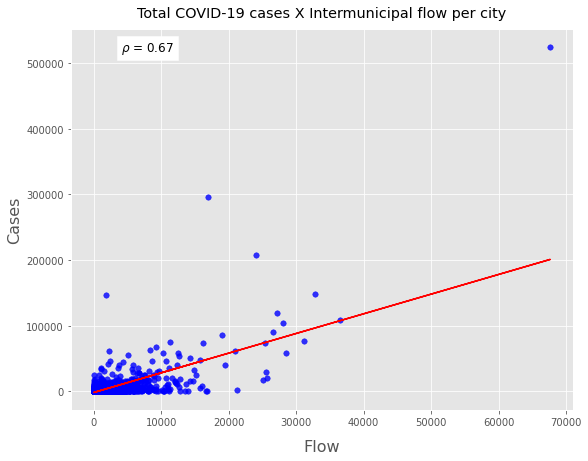

In [156]:
cities_df = df_flow_covid(OD='BR')
fig,ax = plt.subplots(figsize=(9,7))
ax.scatter(cities_df['flow'], cities_df['totalCases'], s=30, c = 'b',alpha = 0.8)
m, b = np.polyfit(cities_df['flow'], cities_df['totalCases'], 1)
ax.plot(cities_df['flow'], m*np.array(cities_df['flow']) + b ,c= 'r')
ax.set_title('Total COVID-19 cases X Intermunicipal flow per city',pad =12)
ax.set_xlabel('Flow', fontsize = 16, labelpad = 12)
ax.set_ylabel('Cases', fontsize = 16)
rho = (np.corrcoef(cities_df['flow'],cities_df['totalCases'])[0][1])
plt.text(0.1, 0.95,'$\\rho$ = %0.2f' %rho,horizontalalignment='left',verticalalignment='center',
         transform = ax.transAxes,fontsize=12, backgroundcolor='white')
plt.show()

### Scale (b) - State scale, where each instance is a state and considers all states of Brazil.

There is a positive correlation between people's flow and total COVID-19 cases. That possibly means that states that has a high flow of people (such as São Paulo and Minas Gerais), are likely to have more COVID-19 cases. Is that really true? We'll find out by the end of this notebook.

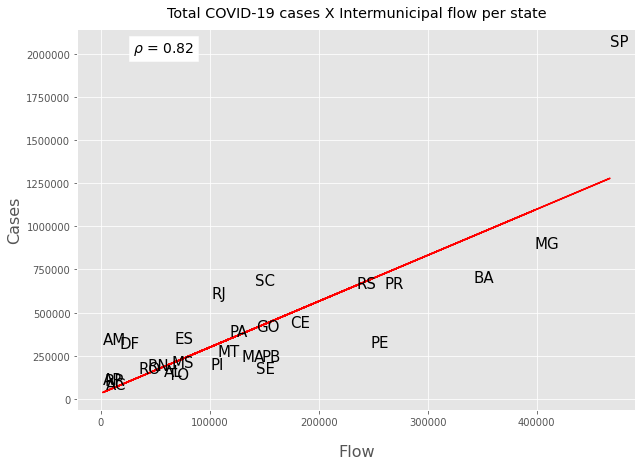

In [157]:
flow_UF, cases_UF = [],[]
for UF in UFS:
    df = df_flow([UF])
    flow_UF.append(df['flow'].sum())
    cases_UF.append(covid_br.groupby('state_id').agg('sum')['totalCases'].loc[UF])
    delay_UF.append(covid_br.groupby('state_id').agg('min')['delay'].loc[UF])
    
    
fig,ax = plt.subplots(figsize=(10,7))
ax.ticklabel_format(useOffset=False, style='plain')
ax.scatter(flow_UF,cases_UF,s=0)
for i, txt in enumerate(UFS_names):
    ax.annotate(txt, (flow_UF[i], cases_UF[i]),fontsize = 15)
m, b = np.polyfit(np.array(flow_UF),np.array(cases_UF), 1)
ax.plot(np.array(flow_UF), m*np.array(flow_UF) + b ,c='r')
ax.set_title('Total COVID-19 cases X Intermunicipal flow per state',pad=12)
ax.set_xlabel('Flow',fontsize=16,labelpad=17)
ax.set_ylabel('Cases',fontsize=16)
r2 = (np.corrcoef(flow_UF,cases_UF)[0][1])
plt.text(0.1, 0.95,'$\\rho$ = %0.2f' %r2,horizontalalignment='left',verticalalignment='center',
         transform = ax.transAxes,fontsize=14, backgroundcolor='white')
plt.show()

### Scale (c) - Municipal scale, where each instance is a city and considers the cities in each state of Brazil.

In many states, such as Rio de Janeiro (RJ), São Paulo (SP) and others, there is a positive correlation between people's flow and total COVID-19 cases. That possibly means that in many states, cities that has a high flow of people that comes from or go to other cities, are likely to have more COVID-19 cases. Is that really true? We'll find out by the end of this notebook.

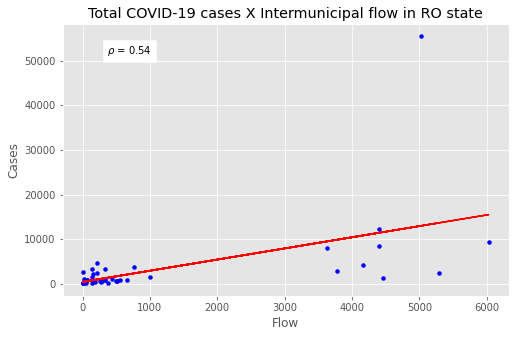

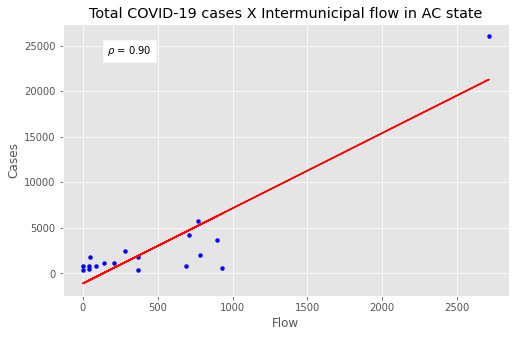

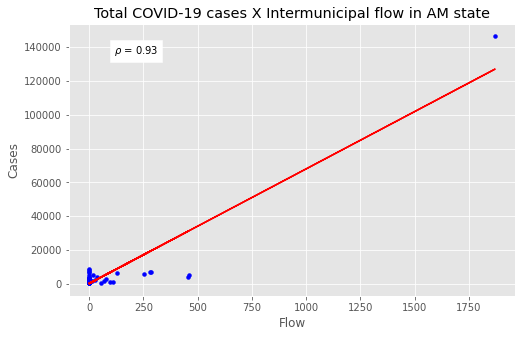

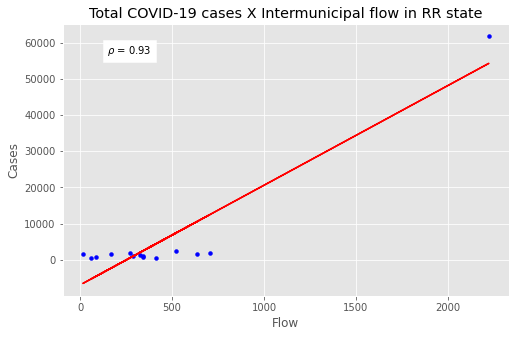

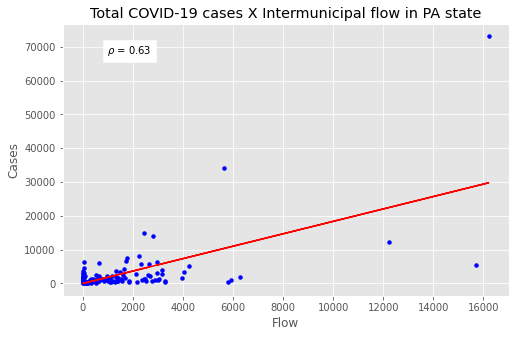

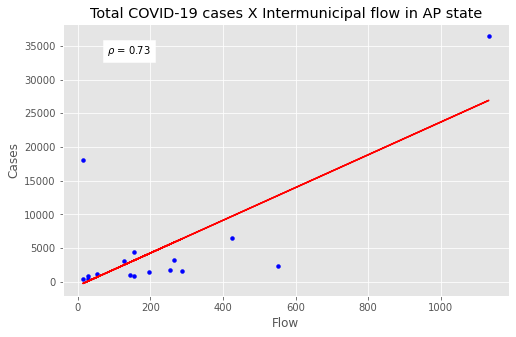

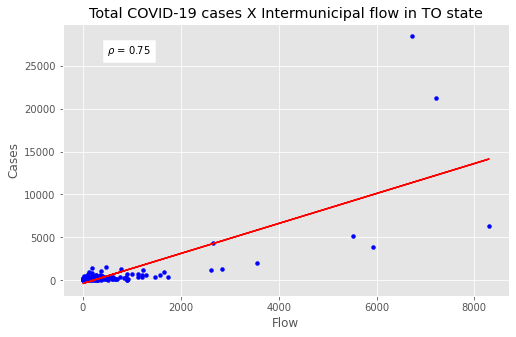

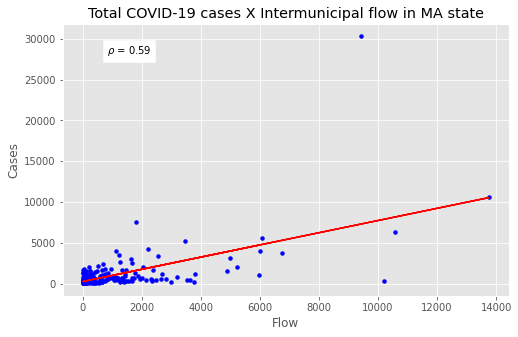

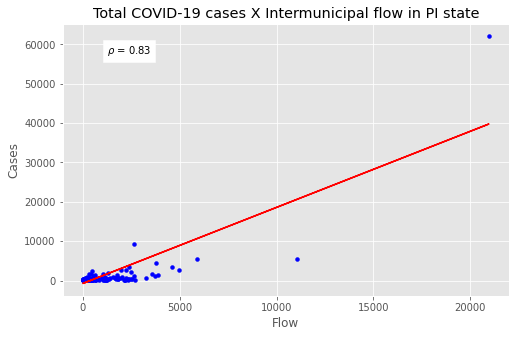

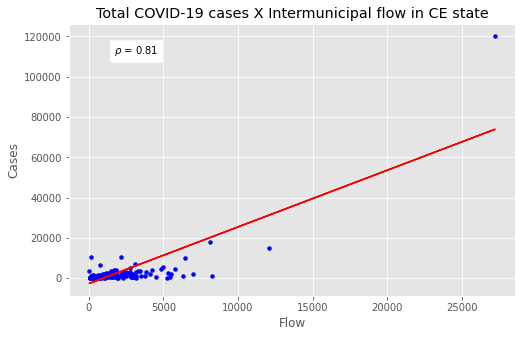

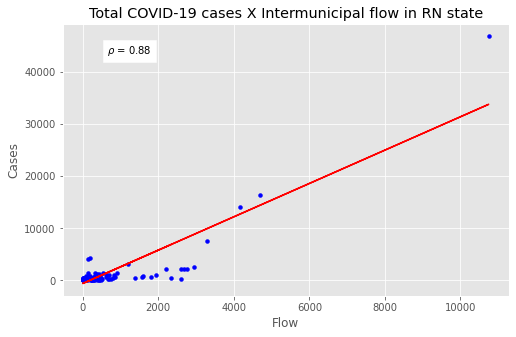

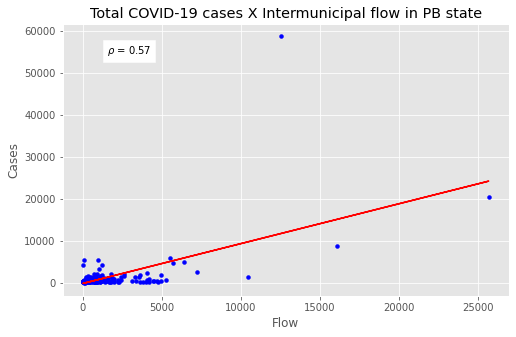

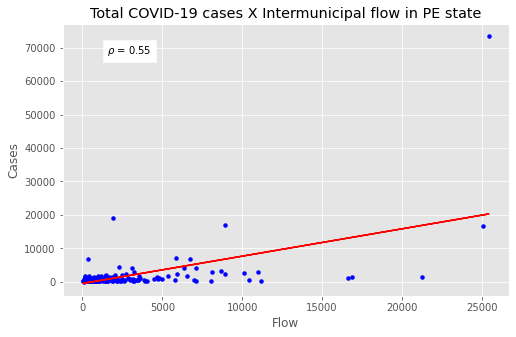

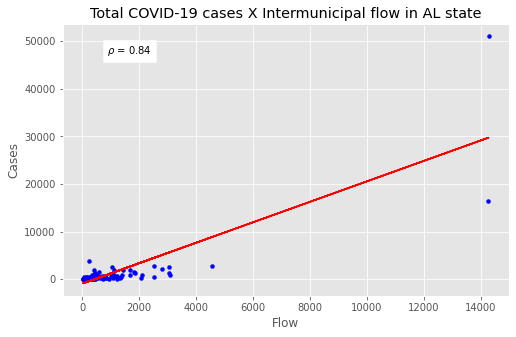

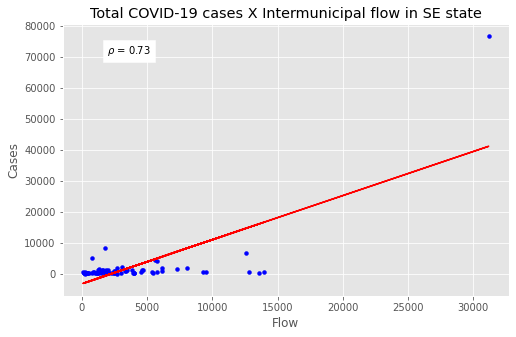

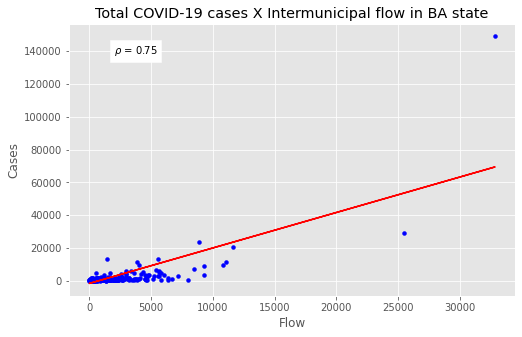

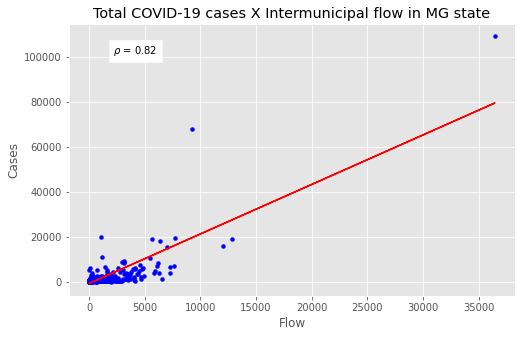

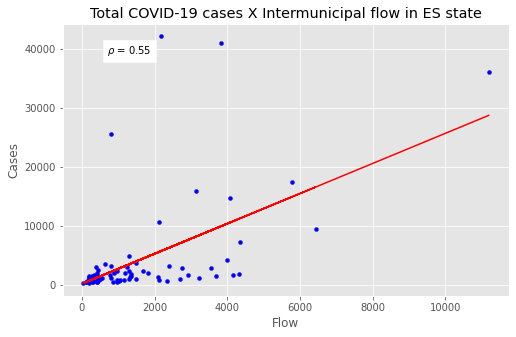

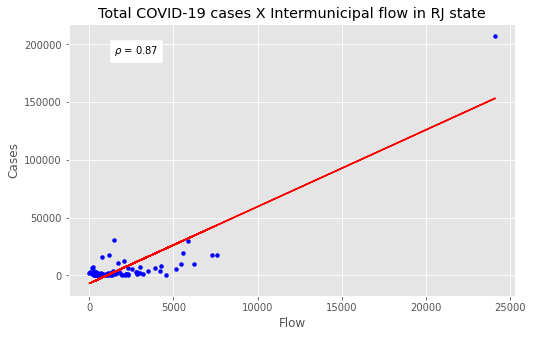

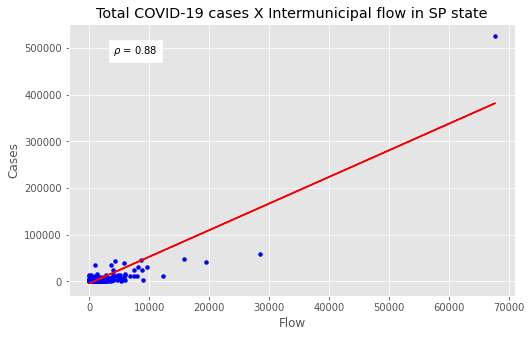

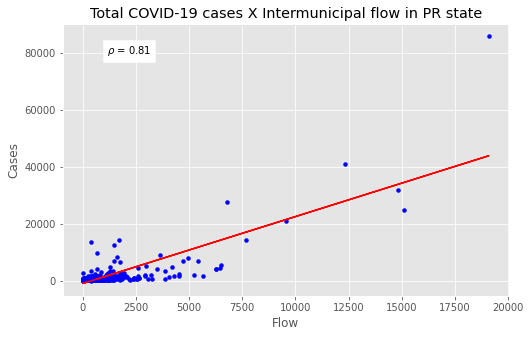

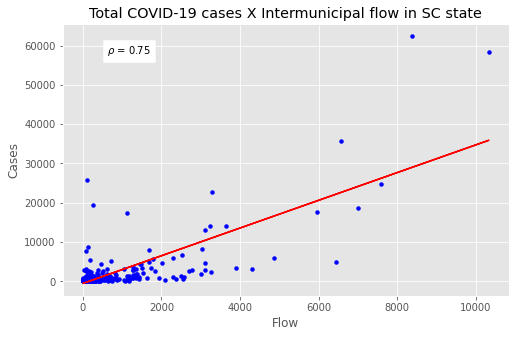

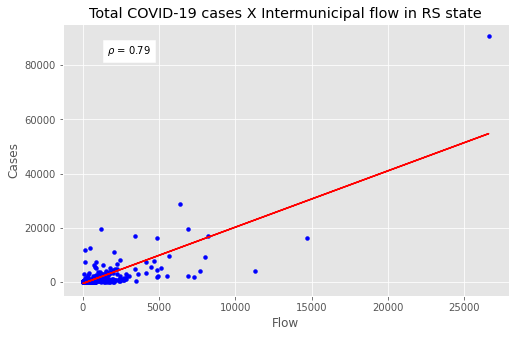

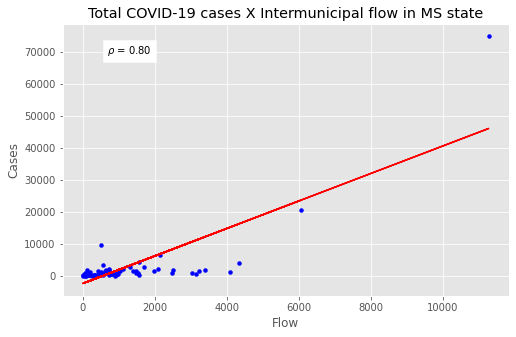

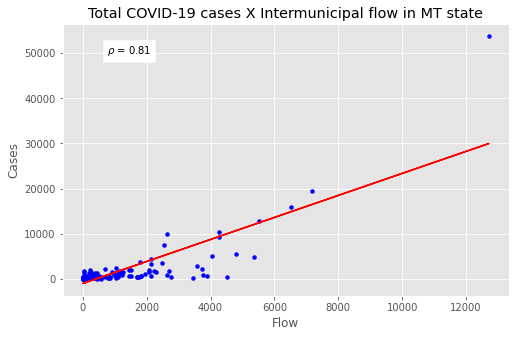

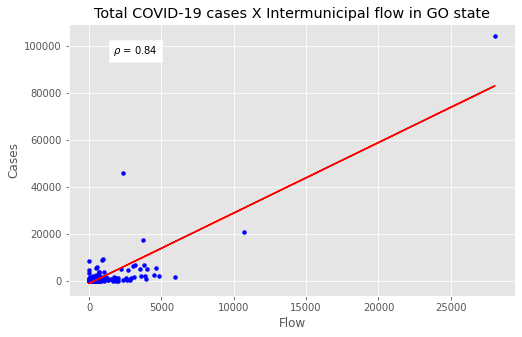

d:\users\igor\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


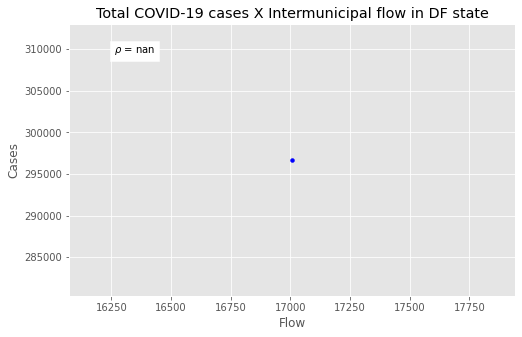

In [158]:
for UF,UF_name in zip(UFS,UFS_names):
    UF_df= df_flow_covid([UF])
    cases_UF = UF_df['totalCases'].values
    flow_UF = UF_df['flow'].values
    fig = plt.figure(figsize=(8.0,5.0))
    ax1 = fig.add_subplot(111)
    ax1.scatter(flow_UF,cases_UF, c='b',s=15, label='real flow')
    plt.title('Total COVID-19 cases X Intermunicipal flow in '+ UF_name+ ' state')
    plt.xlabel('Flow', fontsize=12)
    plt.ylabel('Cases', fontsize=12)
    m, b = np.polyfit(flow_UF,cases_UF, 1)
    plt.plot(flow_UF, m*flow_UF + b,c='r')
    r2 = (np.corrcoef(flow_UF,cases_UF)[0][1])
    plt.text(0.1, 0.9,'$\\rho$ = %0.2f' %r2, horizontalalignment='left',verticalalignment='center',
             transform = ax1.transAxes, backgroundcolor='white')
    plt.show()


## Approach (2) - Using COVID-19 cases per 100k inhabitants data instead of total cases.

### Scale (a) - Municipal scale, where each instance is a city and considers all of cities of Brazil.

No correlation between mobility and COVID-19 can be observed when we consider the cases per 100k inhabitants COVID-19 data  instead of total cases.

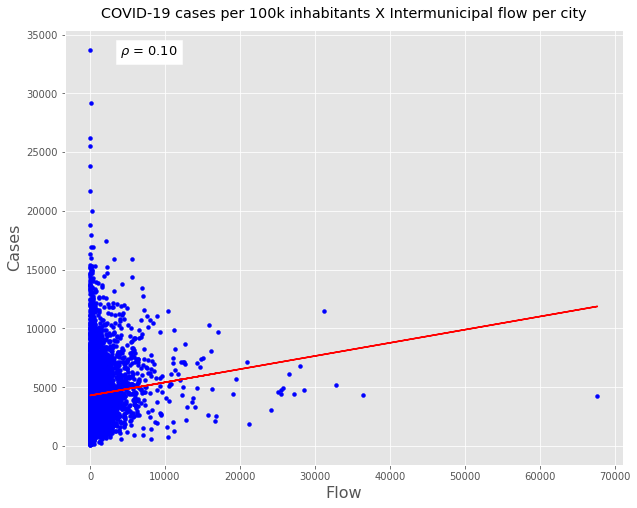

In [159]:
cities_df = df_flow_covid(OD='BR')

fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(cities_df['flow'], cities_df['totalCases_per_100k_inhabitants'], s=15,c='b')
m, b = np.polyfit(cities_df['flow'], cities_df['totalCases_per_100k_inhabitants'], 1)
ax.plot(cities_df['flow'], m*np.array(cities_df['flow']) + b ,c= 'r')
ax.set_title('COVID-19 cases per 100k inhabitants X Intermunicipal flow per city',pad =12)
ax.set_xlabel('Flow', fontsize=16)
ax.set_ylabel('Cases', fontsize=16)
r2 = (np.corrcoef(cities_df['flow'],cities_df['totalCases_per_100k_inhabitants'])[0][1])
plt.text(0.1, 0.95,'$\\rho$ = %0.2f' %r2,horizontalalignment='left',verticalalignment='center',
         transform = ax.transAxes,fontsize=13, backgroundcolor='white')
plt.show()

### Scale (b) - State scale, where each instance is a state and considers all states of Brazil.

Little to no correlation between mobility and COVID-19 can be observed when we consider the cases per 100k inhabitants COVID-19 data instead of total cases.

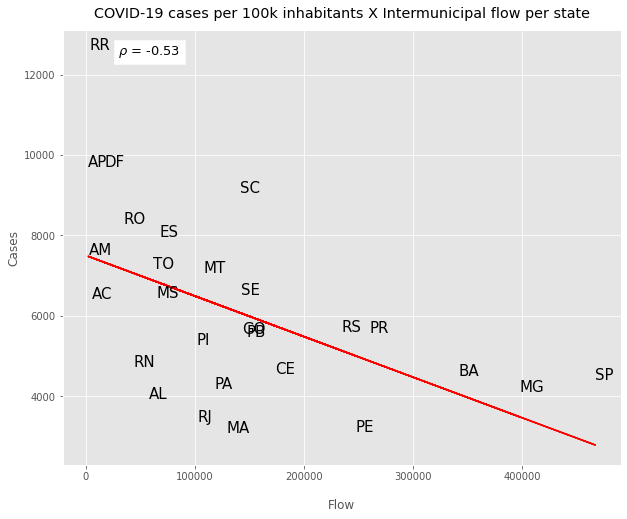

In [160]:
flow_UF, cases_100k_hab_UF= [],[]
for UF in UFS:
    df = df_flow([UF])
    flow_UF.append(df['flow'].sum())
    UF_population = covid_br.groupby('state_id').agg('sum')['population'].loc[UF]
    total_cases_UF = covid_br.groupby('state_id').agg('sum')['totalCases'].loc[UF]
    cases_100k_hab_UF.append((total_cases_UF* 100000)/UF_population)
    
    
fig,ax = plt.subplots(figsize=(10,8))
ax.ticklabel_format(useOffset=False, style='plain')
ax.scatter(flow_UF,cases_100k_hab_UF,s=0)
for i, txt in enumerate(UFS_names):
    ax.annotate(txt, (flow_UF[i], cases_100k_hab_UF[i]), fontsize=15)
m, b = np.polyfit(np.array(flow_UF),np.array(cases_100k_hab_UF), 1)
ax.plot(np.array(flow_UF), m*np.array(flow_UF) + b ,c='r')
ax.set_title('COVID-19 cases per 100k inhabitants X Intermunicipal flow per state',pad=12)
ax.set_xlabel('Flow',fontsize=12,labelpad=17)
ax.set_ylabel('Cases',fontsize=12)
r2 = (np.corrcoef(flow_UF,cases_100k_hab_UF)[0][1])
plt.text(0.1, 0.95,'$\\rho$ = %0.2f' %r2,horizontalalignment='left',verticalalignment='center',
         transform = ax.transAxes,fontsize=13, backgroundcolor='white')
plt.show()

### Scale (c) - Municipal scale, where each instance is a city and considers the cities of each state of Brazil. 

Little to no correlation between mobility and COVID-19 can be observed when we consider the cases per 100k inhabitants COVID-19 data instead of total cases.

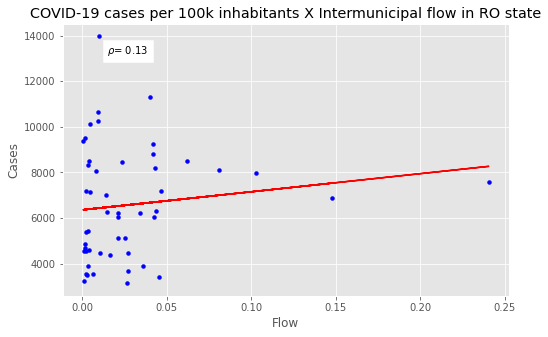

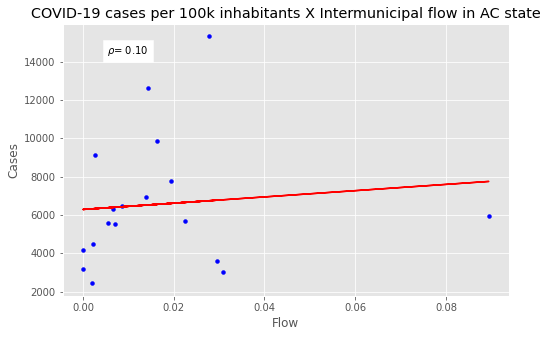

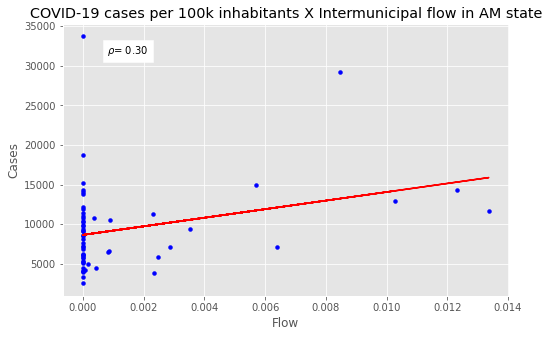

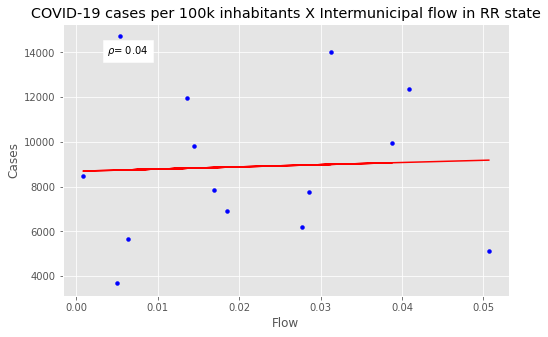

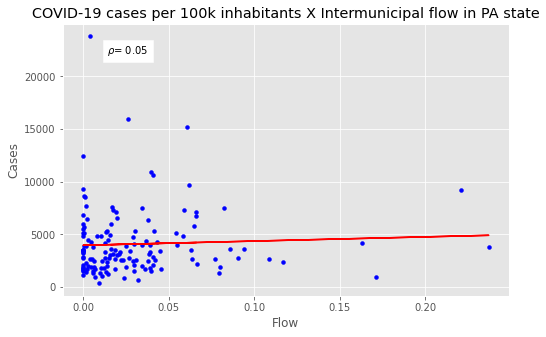

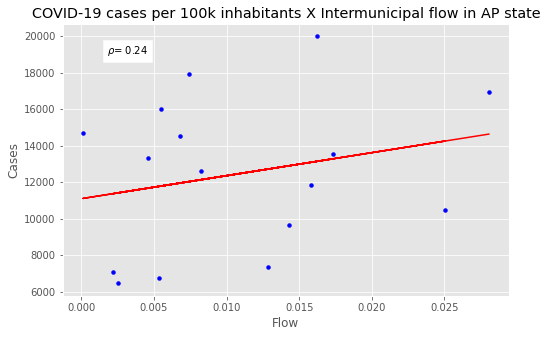

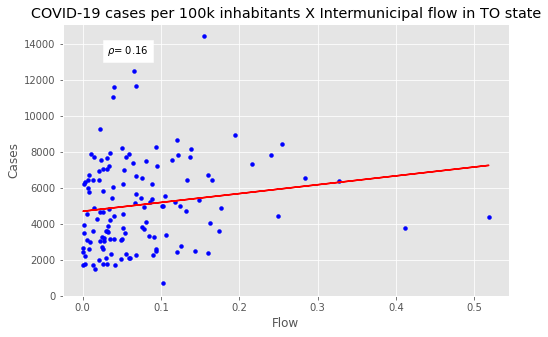

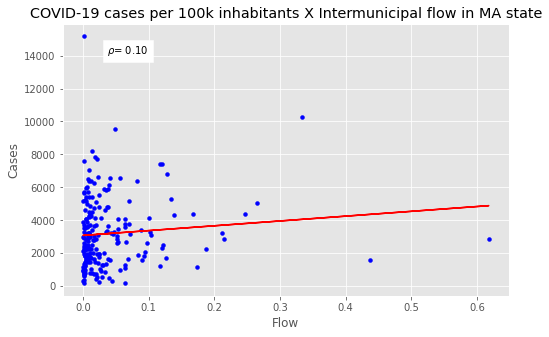

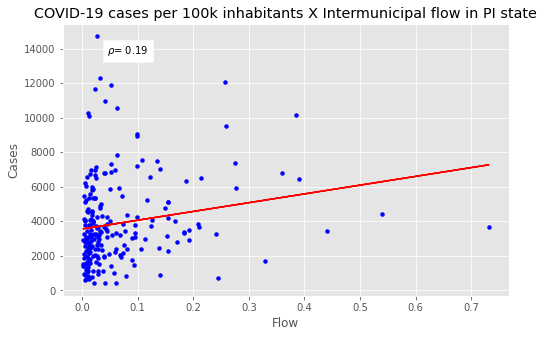

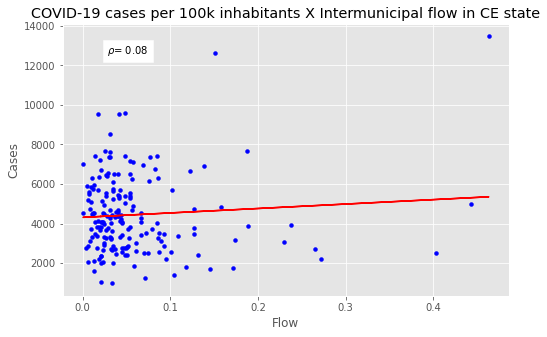

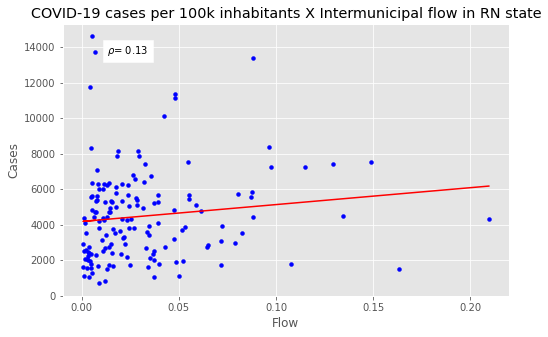

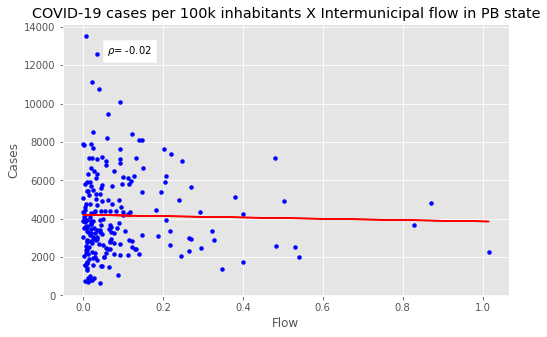

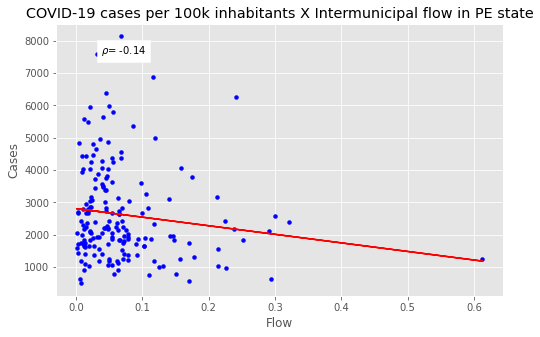

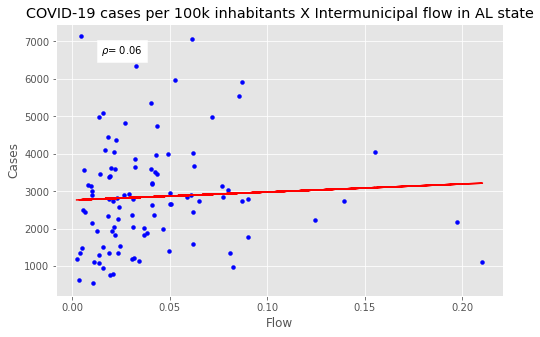

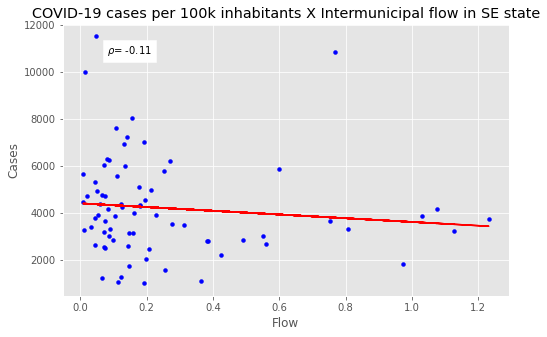

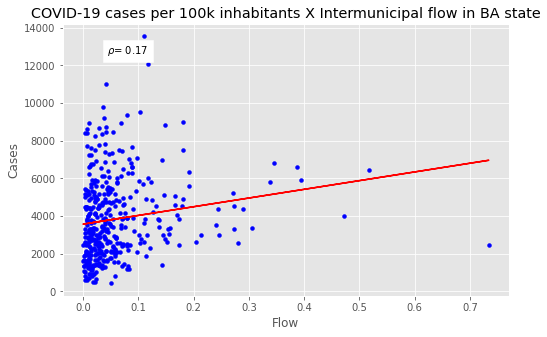

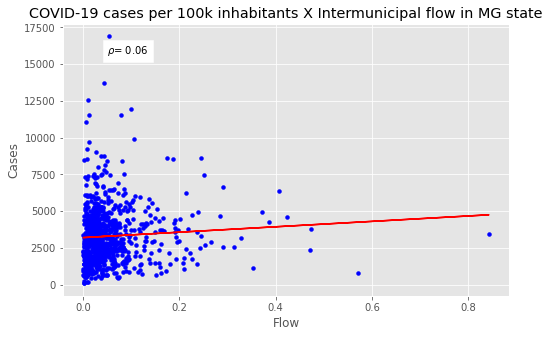

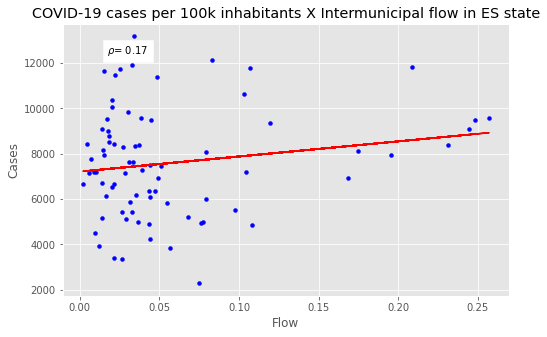

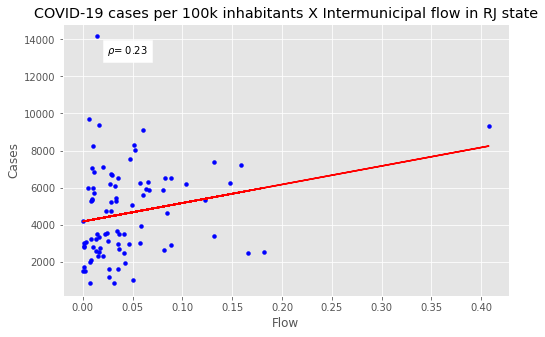

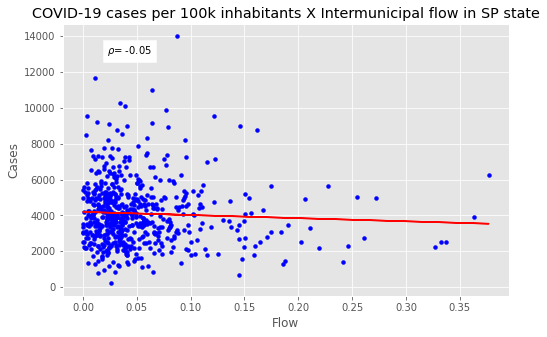

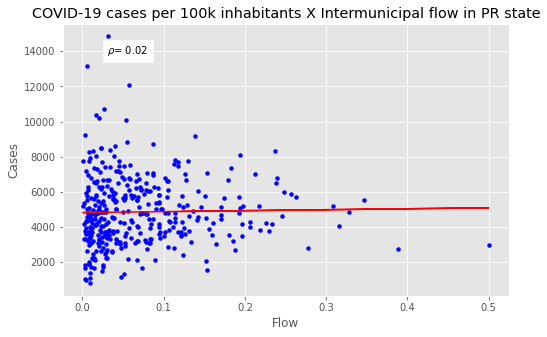

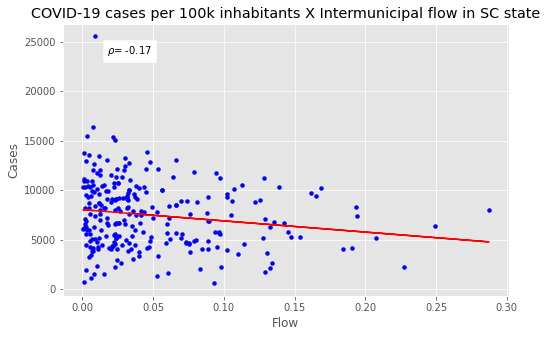

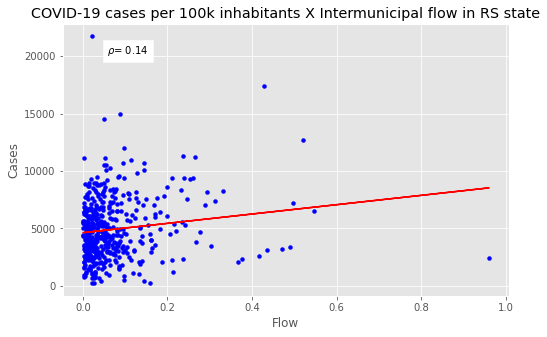

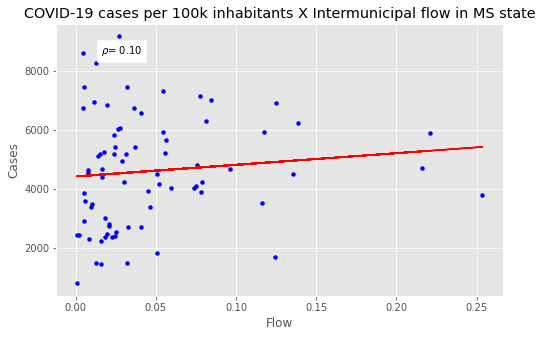

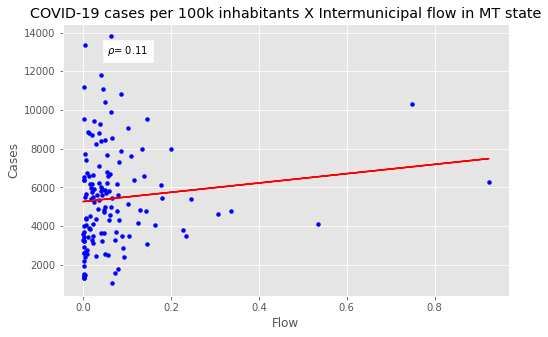

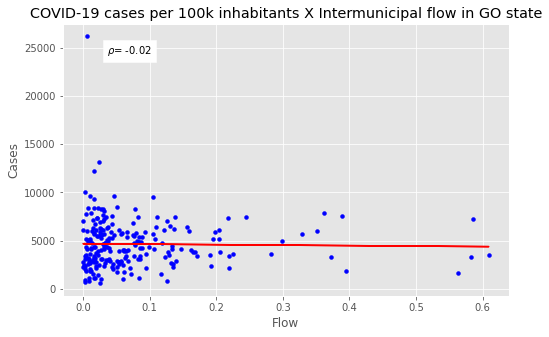

d:\users\igor\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Igor\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


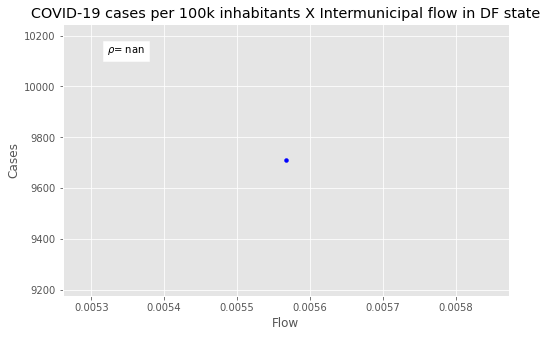

In [161]:
for UF,UF_name in zip(UFS,UFS_names):
    UF_df= df_flow_covid([UF])
    cases_UF = UF_df['totalCases_per_100k_inhabitants'].values
    flow_UF = UF_df['flow']/UF_df['population']
    fig = plt.figure(figsize=(8.0,5.0))
    ax1 = fig.add_subplot(111)
    ax1.scatter(flow_UF,cases_UF, c='b',s=15, label='real flow')
    plt.title('COVID-19 cases per 100k inhabitants X Intermunicipal flow in '+ UF_name+ ' state')
    plt.xlabel('Flow', fontsize=12)
    plt.ylabel('Cases', fontsize=12)
    m, b = np.polyfit(flow_UF,cases_UF, 1)
    plt.plot(flow_UF, m*flow_UF + b,c='r')
    r2 = (np.corrcoef(flow_UF,cases_UF)[0][1])
    plt.text(0.1, 0.9,'$\\rho$= %0.2f' %r2, horizontalalignment='left',verticalalignment='center',
             transform = ax1.transAxes, backgroundcolor='white')
    plt.savefig('output/figures/UFS/por_cidade_da_UF/casos/'+'casos_'+str(UF_name)+'.png') 
    plt.show()

## Conclusion

When using approach 1 (i.e Considering total COVID-19 cases), we could observe a high correlation between human mobility and COVID-19 data. However, with approach 2 (i.e Considering COVID-19 cases per 100 thousand inhabitants), there is no correlation at all between mobility and COVID-19 data. 

But since in both approaches we are using COVID-19 data, why are the results so different? Since approach 1 shows a high correlation between both variables, can we say that a high intermunicipal flow causes COVID-19 cases to rise? And the answer is NO. At least with this data.

This is due to a very known principle in statistics that states that correlation does not imply causation. When 2 variables X and Y are correlated with each other, there are 4 possible reasons:

* X causes Y
* Y causes X
* Neither of them cause each other
* Another variable C causes both X and Y

In our case, what happens is the last one. That means that another variable causes both total COVID-19 cases and people's flow to rise, and that variable is the POPULATION. That is why when using approach 2 there was no correlation, because when using the cases per 100k inhabitants we remove the influence of the population.